## Model Comparison

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize


### Define Simple CNN Model

In [2]:
# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Define training process

In [6]:
def trainingModel(model, tr_loader, va_loader,learning_rate, num_epoch=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    # Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # History
    history = {"train_loss": [], "valid_loss": [], "valid_accuracy": []}

    # Track the best model
    best_valid_loss = float('inf')  # Initialize to infinity
    best_model_wts = None

    # Training and Validation Loop with Progress Updates
    epochs = num_epoch
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        # Use tqdm for batch-level progress
        for images, labels in tqdm(tr_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(tr_loader)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
        
        # Validation Phase
        model.eval()
        valid_loss = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            # Use tqdm for validation progress
            for images, labels in tqdm(va_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(va_loader)
        valid_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        epoch_duration = time.time() - start_time

        # Store in history
        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["valid_accuracy"].append(valid_accuracy)

        # Print the progress with more metrics and time per epoch
        print(f"Epoch {epoch+1}/{epochs} - Duration: {epoch_duration:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1 Score: {valid_f1:.4f}, Valid Precision: {valid_precision:.4f}, Valid Recall: {valid_recall:.4f}")

        # Save the best model weights
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = model.state_dict()

    return model, history, best_model_wts

### Define training Dataloader

In [7]:
def loadTrainingData(i_size, b_size, original=True):
    # Data transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Datasets
    train_dataset = datasets.ImageFolder("archive/train", transform=train_transforms)
    valid_dataset = datasets.ImageFolder("archive/valid", transform=valid_test_transforms)
    test_dataset = datasets.ImageFolder("archive/test", transform=valid_test_transforms)

    # DataLoaders
    batch_size = b_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if(original == False):
        train_original = datasets.ImageFolder("archive/train", transform=valid_test_transforms) # original training set
        augmented_dataset = datasets.ImageFolder("archive/train", transform=train_transforms) # trainsformed training set
        train_combined = ConcatDataset([train_original, augmented_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(valid_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [8]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set CUDA seed (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # for all GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

============================================================================================================

### Final CNN Model
Compared with the baseline parameters:
- Larger batch size doesn't make a big difference. 
- Larger input size also has similar performance but much slower. We don't choose it.
- Smaller learning rate is not considered since it might need too many epoch to achieve a similar performance.
- Using expanded training set has the best result. 
- Considering some other models do not have the best performance on expanded training set, we would not choose it as well in simple CNN. 

Thus, we stay on the baseline group of parameters.<br>
Final CNN Model parameters:<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, original training set, num_epoch = 20

In [22]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model_cnn, history_cnn, best_wts_cnn = trainingModel(model, train_loader, valid_loader, learning_rate=0.001, num_epoch=20)

Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/20 - Duration: 19.81s
Train Loss: 4.0082, Train Precision: 0.0707, Train Recall: 0.0717
Valid Loss: 3.1074, Valid Accuracy: 0.2340, Valid F1 Score: 0.1877, Valid Precision: 0.5644, Valid Recall: 0.2340


Epoch 2/20 - Duration: 18.79s
Train Loss: 3.0045, Train Precision: 0.2131, Train Recall: 0.2260
Valid Loss: 2.3507, Valid Accuracy: 0.4140, Valid F1 Score: 0.3833, Valid Precision: 0.5208, Valid Recall: 0.4140


Epoch 3/20 - Duration: 19.10s
Train Loss: 2.4838, Train Precision: 0.3282, Train Recall: 0.3409
Valid Loss: 1.8782, Valid Accuracy: 0.5400, Valid F1 Score: 0.5250, Valid Precision: 0.6190, Valid Recall: 0.5400


Epoch 4/20 - Duration: 18.73s
Train Loss: 2.1917, Train Precision: 0.3947, Train Recall: 0.4029
Valid Loss: 1.5543, Valid Accuracy: 0.6040, Valid F1 Score: 0.5866, Valid Precision: 0.6534, Valid Recall: 0.6040


Epoch 5/20 - Duration: 18.95s
Train Loss: 2.0153, Train Precision: 0.4367, Train Recall: 0.4435
Valid Loss: 1.4344, Valid Accuracy: 0.6320, Valid F1 Score: 0.6109, Valid Precision: 0.6882, Valid Recall: 0.6320


Epoch 6/20 - Duration: 18.81s
Train Loss: 1.8560, Train Precision: 0.4758, Train Recall: 0.4809
Valid Loss: 1.3021, Valid Accuracy: 0.6740, Valid F1 Score: 0.6525, Valid Precision: 0.7140, Valid Recall: 0.6740


Epoch 7/20 - Duration: 18.90s
Train Loss: 1.7448, Train Precision: 0.5048, Train Recall: 0.5087
Valid Loss: 1.1934, Valid Accuracy: 0.6800, Valid F1 Score: 0.6700, Valid Precision: 0.7199, Valid Recall: 0.6800


Epoch 8/20 - Duration: 18.70s
Train Loss: 1.6508, Train Precision: 0.5359, Train Recall: 0.5386
Valid Loss: 1.1383, Valid Accuracy: 0.6800, Valid F1 Score: 0.6623, Valid Precision: 0.7367, Valid Recall: 0.6800


Epoch 9/20 - Duration: 19.05s
Train Loss: 1.5802, Train Precision: 0.5499, Train Recall: 0.5528
Valid Loss: 1.0884, Valid Accuracy: 0.7040, Valid F1 Score: 0.6893, Valid Precision: 0.7428, Valid Recall: 0.7040


Epoch 10/20 - Duration: 19.12s
Train Loss: 1.5089, Train Precision: 0.5697, Train Recall: 0.5703
Valid Loss: 1.0465, Valid Accuracy: 0.7320, Valid F1 Score: 0.7212, Valid Precision: 0.7829, Valid Recall: 0.7320


Epoch 11/20 - Duration: 19.22s
Train Loss: 1.4539, Train Precision: 0.5844, Train Recall: 0.5861
Valid Loss: 0.9803, Valid Accuracy: 0.7380, Valid F1 Score: 0.7257, Valid Precision: 0.7799, Valid Recall: 0.7380


Epoch 12/20 - Duration: 18.93s
Train Loss: 1.4102, Train Precision: 0.5966, Train Recall: 0.5984
Valid Loss: 1.0048, Valid Accuracy: 0.7180, Valid F1 Score: 0.7118, Valid Precision: 0.7794, Valid Recall: 0.7180


Epoch 13/20 - Duration: 20.55s
Train Loss: 1.3594, Train Precision: 0.6032, Train Recall: 0.6041
Valid Loss: 0.9095, Valid Accuracy: 0.7540, Valid F1 Score: 0.7467, Valid Precision: 0.8012, Valid Recall: 0.7540


Epoch 14/20 - Duration: 19.01s
Train Loss: 1.3213, Train Precision: 0.6127, Train Recall: 0.6140
Valid Loss: 0.8539, Valid Accuracy: 0.7500, Valid F1 Score: 0.7312, Valid Precision: 0.7975, Valid Recall: 0.7500


Epoch 15/20 - Duration: 18.97s
Train Loss: 1.2932, Train Precision: 0.6228, Train Recall: 0.6248
Valid Loss: 0.8412, Valid Accuracy: 0.7620, Valid F1 Score: 0.7508, Valid Precision: 0.8012, Valid Recall: 0.7620


Epoch 16/20 - Duration: 19.04s
Train Loss: 1.2568, Train Precision: 0.6320, Train Recall: 0.6329
Valid Loss: 0.8589, Valid Accuracy: 0.7540, Valid F1 Score: 0.7385, Valid Precision: 0.7972, Valid Recall: 0.7540


Epoch 17/20 - Duration: 18.80s
Train Loss: 1.2051, Train Precision: 0.6509, Train Recall: 0.6524
Valid Loss: 0.8286, Valid Accuracy: 0.7700, Valid F1 Score: 0.7602, Valid Precision: 0.8072, Valid Recall: 0.7700


Epoch 18/20 - Duration: 18.55s
Train Loss: 1.1867, Train Precision: 0.6491, Train Recall: 0.6505
Valid Loss: 0.8314, Valid Accuracy: 0.7800, Valid F1 Score: 0.7729, Valid Precision: 0.8172, Valid Recall: 0.7800


Epoch 19/20 - Duration: 19.06s
Train Loss: 1.1496, Train Precision: 0.6632, Train Recall: 0.6639
Valid Loss: 0.8213, Valid Accuracy: 0.7860, Valid F1 Score: 0.7703, Valid Precision: 0.8196, Valid Recall: 0.7860


Epoch 20/20 - Duration: 18.61s
Train Loss: 1.1272, Train Precision: 0.6708, Train Recall: 0.6705
Valid Loss: 0.7780, Valid Accuracy: 0.7920, Valid F1 Score: 0.7785, Valid Precision: 0.8350, Valid Recall: 0.7920


### Final ResNet18 Model
Compared with the baseline parameters:
- All the other grouops give similar results
- Using smaller learning rate, the performance improved even with the same number of epoch.

We assume this group of paramters can give the best performance.
<br>
Final ResNet18 Model parameters:<br>
input size 64 x 64, batch_size = 64, learning rate = 0.0001, original training set, num_epoch = 20

In [23]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_resnet18, history_resnet, best_wts_resnet = trainingModel(model, train_loader, valid_loader, learning_rate=0.0001, num_epoch=20)

Training set size: 12594
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Duration: 31.09s
Train Loss: 2.7482, Train Precision: 0.4377, Train Recall: 0.4122
Valid Loss: 1.1863, Valid Accuracy: 0.7280, Valid F1 Score: 0.7148, Valid Precision: 0.7629, Valid Recall: 0.7280


Epoch 2/20 - Duration: 33.56s
Train Loss: 0.9560, Train Precision: 0.7705, Train Recall: 0.7672
Valid Loss: 0.5662, Valid Accuracy: 0.8640, Valid F1 Score: 0.8598, Valid Precision: 0.8834, Valid Recall: 0.8640


Epoch 3/20 - Duration: 33.24s
Train Loss: 0.5938, Train Precision: 0.8491, Train Recall: 0.8475
Valid Loss: 0.4140, Valid Accuracy: 0.9060, Valid F1 Score: 0.9020, Valid Precision: 0.9209, Valid Recall: 0.9060


Epoch 4/20 - Duration: 32.96s
Train Loss: 0.4508, Train Precision: 0.8817, Train Recall: 0.8802
Valid Loss: 0.3486, Valid Accuracy: 0.9060, Valid F1 Score: 0.9032, Valid Precision: 0.9234, Valid Recall: 0.9060


Epoch 5/20 - Duration: 33.14s
Train Loss: 0.3541, Train Precision: 0.9040, Train Recall: 0.9033
Valid Loss: 0.3473, Valid Accuracy: 0.9080, Valid F1 Score: 0.9032, Valid Precision: 0.9237, Valid Recall: 0.9080


Epoch 6/20 - Duration: 31.60s
Train Loss: 0.2886, Train Precision: 0.9197, Train Recall: 0.9192
Valid Loss: 0.3369, Valid Accuracy: 0.9160, Valid F1 Score: 0.9134, Valid Precision: 0.9250, Valid Recall: 0.9160


Epoch 7/20 - Duration: 31.57s
Train Loss: 0.2432, Train Precision: 0.9334, Train Recall: 0.9327
Valid Loss: 0.3310, Valid Accuracy: 0.9240, Valid F1 Score: 0.9220, Valid Precision: 0.9328, Valid Recall: 0.9240


Epoch 8/20 - Duration: 31.22s
Train Loss: 0.2086, Train Precision: 0.9410, Train Recall: 0.9403
Valid Loss: 0.3068, Valid Accuracy: 0.9220, Valid F1 Score: 0.9203, Valid Precision: 0.9310, Valid Recall: 0.9220


Epoch 9/20 - Duration: 31.41s
Train Loss: 0.1814, Train Precision: 0.9489, Train Recall: 0.9486
Valid Loss: 0.3326, Valid Accuracy: 0.9140, Valid F1 Score: 0.9112, Valid Precision: 0.9282, Valid Recall: 0.9140


Epoch 10/20 - Duration: 31.24s
Train Loss: 0.1595, Train Precision: 0.9538, Train Recall: 0.9537
Valid Loss: 0.2935, Valid Accuracy: 0.9120, Valid F1 Score: 0.9098, Valid Precision: 0.9230, Valid Recall: 0.9120


Epoch 11/20 - Duration: 31.32s
Train Loss: 0.1357, Train Precision: 0.9602, Train Recall: 0.9599
Valid Loss: 0.3421, Valid Accuracy: 0.9160, Valid F1 Score: 0.9142, Valid Precision: 0.9286, Valid Recall: 0.9160


Epoch 12/20 - Duration: 31.41s
Train Loss: 0.1222, Train Precision: 0.9645, Train Recall: 0.9644
Valid Loss: 0.3390, Valid Accuracy: 0.9240, Valid F1 Score: 0.9207, Valid Precision: 0.9367, Valid Recall: 0.9240


Epoch 13/20 - Duration: 32.73s
Train Loss: 0.1073, Train Precision: 0.9682, Train Recall: 0.9683
Valid Loss: 0.3700, Valid Accuracy: 0.9160, Valid F1 Score: 0.9147, Valid Precision: 0.9285, Valid Recall: 0.9160


Epoch 14/20 - Duration: 31.33s
Train Loss: 0.1008, Train Precision: 0.9709, Train Recall: 0.9705
Valid Loss: 0.3511, Valid Accuracy: 0.9160, Valid F1 Score: 0.9130, Valid Precision: 0.9289, Valid Recall: 0.9160


Epoch 15/20 - Duration: 31.63s
Train Loss: 0.0960, Train Precision: 0.9711, Train Recall: 0.9711
Valid Loss: 0.4049, Valid Accuracy: 0.9080, Valid F1 Score: 0.9038, Valid Precision: 0.9272, Valid Recall: 0.9080


Epoch 16/20 - Duration: 31.51s
Train Loss: 0.0953, Train Precision: 0.9728, Train Recall: 0.9729
Valid Loss: 0.3503, Valid Accuracy: 0.9140, Valid F1 Score: 0.9113, Valid Precision: 0.9285, Valid Recall: 0.9140


Epoch 17/20 - Duration: 31.34s
Train Loss: 0.0758, Train Precision: 0.9789, Train Recall: 0.9789
Valid Loss: 0.3292, Valid Accuracy: 0.9180, Valid F1 Score: 0.9153, Valid Precision: 0.9279, Valid Recall: 0.9180


Epoch 18/20 - Duration: 31.33s
Train Loss: 0.0778, Train Precision: 0.9771, Train Recall: 0.9769
Valid Loss: 0.3538, Valid Accuracy: 0.9300, Valid F1 Score: 0.9277, Valid Precision: 0.9403, Valid Recall: 0.9300


Epoch 19/20 - Duration: 31.14s
Train Loss: 0.0690, Train Precision: 0.9785, Train Recall: 0.9785
Valid Loss: 0.3589, Valid Accuracy: 0.9260, Valid F1 Score: 0.9236, Valid Precision: 0.9333, Valid Recall: 0.9260


Epoch 20/20 - Duration: 32.15s
Train Loss: 0.0763, Train Precision: 0.9782, Train Recall: 0.9780
Valid Loss: 0.3530, Valid Accuracy: 0.9220, Valid F1 Score: 0.9190, Valid Precision: 0.9340, Valid Recall: 0.9220


### Final EfficientNet Model
Compared with the baseline parameters:
- All the other grouops give similar and good results
- Using smaller learning rate, the accuracy is somehow lower, but still above 0.9. The running time is also good.
- The other two groups consume much longer time. We decide not to continue on them at this time.

We assume the group with smaller learning rate can have better performance.
<br>
Final EfficientNet Model parameters:<br>
input size 64 x 64, batch_size = 64, learning rate = 0.0001, original training set, num_epoch = 20

In [24]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_efficientnet, history_effiNet, best_wts_effiNet = trainingModel(model, train_loader, valid_loader, learning_rate=0.0001, num_epoch=20)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/20 - Duration: 64.16s
Train Loss: 4.2753, Train Precision: 0.0861, Train Recall: 0.0926
Valid Loss: 3.6556, Valid Accuracy: 0.2600, Valid F1 Score: 0.2176, Valid Precision: 0.3476, Valid Recall: 0.2600


Epoch 2/20 - Duration: 49.98s
Train Loss: 2.9813, Train Precision: 0.3772, Train Recall: 0.3854
Valid Loss: 2.2391, Valid Accuracy: 0.5300, Valid F1 Score: 0.4995, Valid Precision: 0.6187, Valid Recall: 0.5300


Epoch 3/20 - Duration: 49.70s
Train Loss: 1.8239, Train Precision: 0.6099, Train Recall: 0.5955
Valid Loss: 1.3200, Valid Accuracy: 0.7080, Valid F1 Score: 0.6882, Valid Precision: 0.7750, Valid Recall: 0.7080


Epoch 4/20 - Duration: 49.14s
Train Loss: 1.1835, Train Precision: 0.7132, Train Recall: 0.7079
Valid Loss: 0.8882, Valid Accuracy: 0.8040, Valid F1 Score: 0.7968, Valid Precision: 0.8423, Valid Recall: 0.8040


Epoch 5/20 - Duration: 46.45s
Train Loss: 0.8756, Train Precision: 0.7747, Train Recall: 0.7717
Valid Loss: 0.6662, Valid Accuracy: 0.8220, Valid F1 Score: 0.8136, Valid Precision: 0.8552, Valid Recall: 0.8220


Epoch 6/20 - Duration: 45.79s
Train Loss: 0.7023, Train Precision: 0.8100, Train Recall: 0.8082
Valid Loss: 0.5566, Valid Accuracy: 0.8520, Valid F1 Score: 0.8466, Valid Precision: 0.8707, Valid Recall: 0.8520


Epoch 7/20 - Duration: 45.48s
Train Loss: 0.5841, Train Precision: 0.8359, Train Recall: 0.8356
Valid Loss: 0.4750, Valid Accuracy: 0.8800, Valid F1 Score: 0.8776, Valid Precision: 0.8974, Valid Recall: 0.8800


Epoch 8/20 - Duration: 45.10s
Train Loss: 0.5073, Train Precision: 0.8602, Train Recall: 0.8593
Valid Loss: 0.4252, Valid Accuracy: 0.8920, Valid F1 Score: 0.8877, Valid Precision: 0.9064, Valid Recall: 0.8920


Epoch 9/20 - Duration: 44.93s
Train Loss: 0.4381, Train Precision: 0.8761, Train Recall: 0.8749
Valid Loss: 0.3948, Valid Accuracy: 0.8980, Valid F1 Score: 0.8946, Valid Precision: 0.9121, Valid Recall: 0.8980


Epoch 10/20 - Duration: 45.38s
Train Loss: 0.3913, Train Precision: 0.8877, Train Recall: 0.8874
Valid Loss: 0.3749, Valid Accuracy: 0.8920, Valid F1 Score: 0.8886, Valid Precision: 0.9059, Valid Recall: 0.8920


Epoch 11/20 - Duration: 44.90s
Train Loss: 0.3523, Train Precision: 0.8990, Train Recall: 0.8981
Valid Loss: 0.3726, Valid Accuracy: 0.8980, Valid F1 Score: 0.8951, Valid Precision: 0.9090, Valid Recall: 0.8980


Epoch 12/20 - Duration: 44.81s
Train Loss: 0.3063, Train Precision: 0.9105, Train Recall: 0.9103
Valid Loss: 0.3560, Valid Accuracy: 0.9060, Valid F1 Score: 0.9032, Valid Precision: 0.9141, Valid Recall: 0.9060


Epoch 13/20 - Duration: 47.62s
Train Loss: 0.2736, Train Precision: 0.9175, Train Recall: 0.9168
Valid Loss: 0.3362, Valid Accuracy: 0.9160, Valid F1 Score: 0.9134, Valid Precision: 0.9228, Valid Recall: 0.9160


Epoch 14/20 - Duration: 44.95s
Train Loss: 0.2492, Train Precision: 0.9248, Train Recall: 0.9242
Valid Loss: 0.3407, Valid Accuracy: 0.9120, Valid F1 Score: 0.9097, Valid Precision: 0.9221, Valid Recall: 0.9120


Epoch 15/20 - Duration: 44.90s
Train Loss: 0.2241, Train Precision: 0.9324, Train Recall: 0.9319
Valid Loss: 0.3266, Valid Accuracy: 0.9200, Valid F1 Score: 0.9184, Valid Precision: 0.9300, Valid Recall: 0.9200


Epoch 16/20 - Duration: 44.97s
Train Loss: 0.2078, Train Precision: 0.9392, Train Recall: 0.9385
Valid Loss: 0.3126, Valid Accuracy: 0.9260, Valid F1 Score: 0.9243, Valid Precision: 0.9358, Valid Recall: 0.9260


Epoch 17/20 - Duration: 45.06s
Train Loss: 0.1907, Train Precision: 0.9438, Train Recall: 0.9435
Valid Loss: 0.3140, Valid Accuracy: 0.9180, Valid F1 Score: 0.9166, Valid Precision: 0.9258, Valid Recall: 0.9180


Epoch 18/20 - Duration: 45.18s
Train Loss: 0.1699, Train Precision: 0.9468, Train Recall: 0.9465
Valid Loss: 0.2873, Valid Accuracy: 0.9240, Valid F1 Score: 0.9230, Valid Precision: 0.9350, Valid Recall: 0.9240


Epoch 19/20 - Duration: 45.32s
Train Loss: 0.1488, Train Precision: 0.9551, Train Recall: 0.9548
Valid Loss: 0.2865, Valid Accuracy: 0.9220, Valid F1 Score: 0.9202, Valid Precision: 0.9291, Valid Recall: 0.9220


Epoch 20/20 - Duration: 44.96s
Train Loss: 0.1387, Train Precision: 0.9590, Train Recall: 0.9584
Valid Loss: 0.2886, Valid Accuracy: 0.9320, Valid F1 Score: 0.9307, Valid Precision: 0.9410, Valid Recall: 0.9320


====================================================================================================

### Evaluation

In [ ]:
models_list = [("SimpleCNN", model_cnn), ("ResNet18", model_resnet18), ("EfficientNet", model_efficientnet)]
models_histories = [("SimpleCNN", history_cnn), ("ResNet18", history_resnet), ("EfficientNet", history_effiNet)]

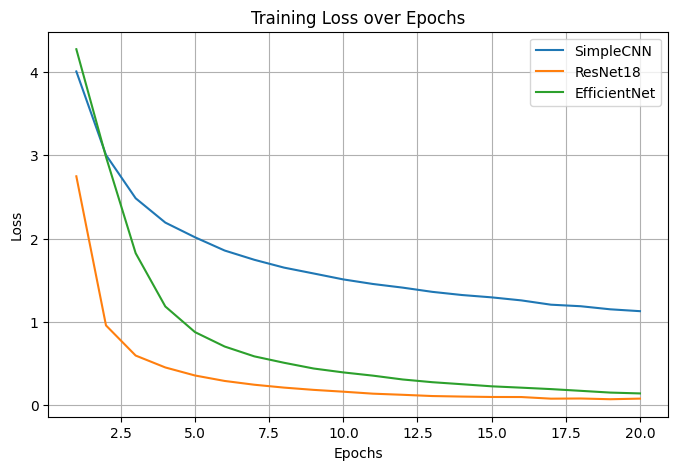

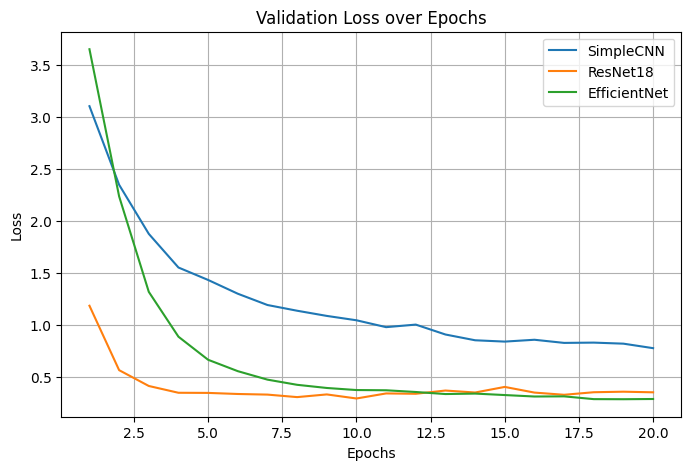

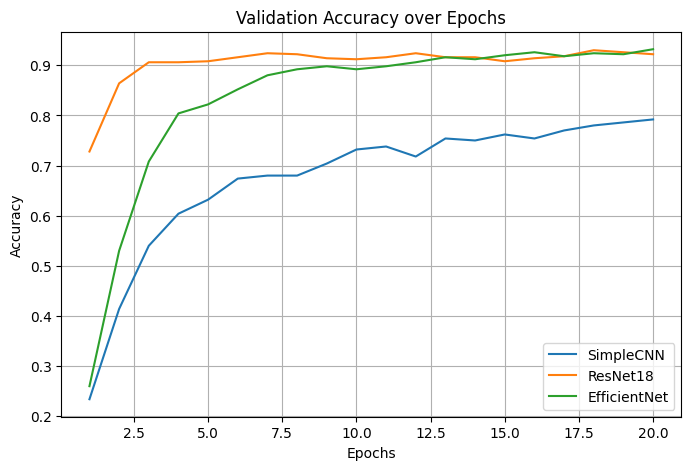

In [30]:
# Plot Training Loss
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 21), history["train_loss"], label=name)
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 21), history["valid_loss"], label=name)
plt.title("Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 21), history["valid_accuracy"], label=name)
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


====================================================================================================
### other evaluation

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, f1, all_labels, all_preds


CNN

In [40]:
valid_loss, valid_accuracy, valid_f1, all_labels, all_preds = evaluate_model(model_cnn, valid_loader, criterion)

# Print results
print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")

# Print the classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)

Validation Loss: 0.7780
Validation Accuracy: 0.7920
Validation F1 Score: 0.7785
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.60      0.75         5
AFRICAN GIANT SWALLOWTAIL       0.83      1.00      0.91         5
           AMERICAN SNOOT       1.00      0.60      0.75         5
                    AN 88       0.83      1.00      0.91         5
                  APPOLLO       0.83      1.00      0.91         5
     ARCIGERA FLOWER MOTH       0.83      1.00      0.91         5
                    ATALA       0.83      1.00      0.91         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      0.80      0.89         5
           BANDED PEACOCK       0.83      1.00      0.91         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       0.75      0.60      0.67         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

ResNet18

In [43]:
valid_loss, valid_accuracy, valid_f1, all_labels, all_preds = evaluate_model(model_resnet18, valid_loader, criterion)

# Print results
print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")

# Print the classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)

Validation Loss: 0.3530
Validation Accuracy: 0.9220
Validation F1 Score: 0.9190
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      0.80      0.89         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      0.60  

EfficientNet

In [44]:
valid_loss, valid_accuracy, valid_f1, all_labels, all_preds = evaluate_model(model_efficientnet, valid_loader, criterion)

# Print results
print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")

# Print the classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)

Validation Loss: 0.2886
Validation Accuracy: 0.9320
Validation F1 Score: 0.9307
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       0.83      1.00      0.91         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       0.80      0.80      0.80         5
            BECKERS WHITE       0.83      1.00      0.91         5
  BIRD CHERRY ERMINE MOTH       0.80      0.80  

====================================================================================================
### Performance on Test set

Evaluation matrix

In [107]:
model.to(device)
model.eval()
all_labels = []
all_preds = []
all_probs = []

# Perform on test set
test_loss = 0.0
with torch.no_grad():
    # Use tqdm for validation progress
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precison: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test Loss: 0.1893
Test Accuracy: 0.9520
Test F1 Score: 0.9508
Test Precison: 0.9587
Test Recall: 0.9520


ROC and AUC

Average AUC: 0.9983


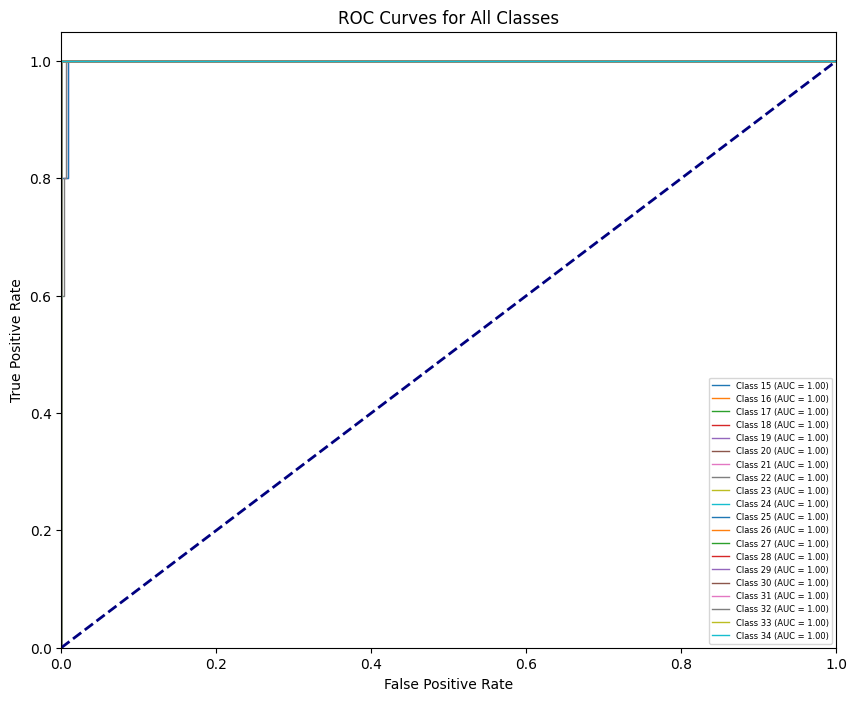

In [108]:
# Compute ROC curve and AUC
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_labels_bin = label_binarize(all_labels, classes=range(100))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# average AUC across all classes
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUC: {average_auc:.4f}')

# Plot ROC curve for some of the classes
plt.figure(figsize=(10, 8))

for i in range(15,35):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right', fontsize=6)
plt.show()


Confusion Matrix on selected class

Confusion Matrix for Class 'ADONIS':
TN: 494, FP: 1, FN: 0, TP: 5


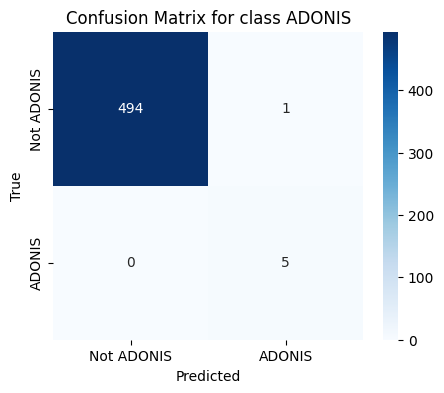

In [97]:
target_class_idx = 0 # Plot the Confusion Matrix for this class
target_class_name = train_dataset.classes[target_class_idx]

# Convert labels and predictions to binary for the target class (0 or 1)
binary_labels = [1 if label == target_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == target_class_idx else 0 for pred in all_preds]

# Calculate the confusion matrix (2x2)
cm = confusion_matrix(binary_labels, binary_preds)

# Confusion Matrix on dataset 2 (expanded training)
TN, FP, FN, TP = cm.ravel()
print(f"Confusion Matrix for Class '{train_dataset.classes[target_class_idx]}':")
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + target_class_name, target_class_name],
            yticklabels=['Not ' + target_class_name, target_class_name])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for class {target_class_name}')
plt.show()